# DM Project



## Notebook Setup

In [1]:
!pip install tensorflow_text
!pip install -q tf-models-official==2.4.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from tqdm import tqdm
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix
import seaborn as sns
from official import nlp
# Load the required submodules
import official.nlp.optimization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understanding the data

In [4]:
!ls /content/drive/MyDrive/Assignments/4.2/DM_Project/data

Constraint_Train.csv  Constraint_Val.csv  english_test_with_labels.csv


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Assignments/4.2/DM_Project/data/Constraint_Train.csv', index_col='id')

In [6]:
df

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real
...,...,...
6416,A tiger tested positive for COVID-19 please st...,fake
6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6418,_A post claims a COVID-19 vaccine has already ...,fake


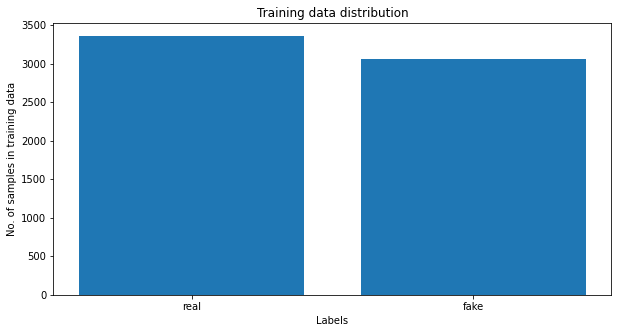

In [7]:
value_counts = df['label'].value_counts()
labels = value_counts.keys()

fig = plt.figure(figsize = (10, 5))
 
plt.bar(labels, value_counts.values)
 
plt.xlabel("Labels")
plt.ylabel("No. of samples in training data")
plt.title("Training data distribution")
plt.show()

In [8]:
with pd.option_context('display.max_colwidth', None):
  print('Positive Samples:')
  print(df[df['label']==labels[0]].head()['tweet'])

Positive Samples:
id
1                                                                                 The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.
2                                                                                                                                              States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux
4                                                                   #IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ
5                                        Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are 

In [9]:
with pd.option_context('display.max_colwidth', None):
  print('Negative Samples:')
  print(df[df['label']==labels[1]].head()['tweet'])

Negative Samples:
id
3                                                                                            Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville
8                                                                                                                                            Obama Calls Trump’s Coronavirus Response A Chaotic Disaster https://t.co/DeDqZEhAsB
9                                                                                                                           ???Clearly, the Obama administration did not leave any kind of game plan for something like this.??�
10                                                    Retraction—Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis - The Lancet https://t.co/L5V2x6G9or
12    The NBA is poised to restart this month. In March we reported on how the 

## Data Preprocessing

In [10]:
train_df = pd.read_csv('/content/drive/MyDrive/Assignments/4.2/DM_Project/data/Constraint_Train.csv', index_col='id')
val_df = pd.read_csv('/content/drive/MyDrive/Assignments/4.2/DM_Project/data/Constraint_Val.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Assignments/4.2/DM_Project/data/english_test_with_labels.csv', index_col='id')

In [11]:
def clean_text(text):
  text = re.sub(r'RT.*:',r'',text) # remove reply tag
  # text = re.sub(r'@[^\s]',r'',text) # remove mentions
  # text = re.sub(r'#[^\s]*','',text) # remove hashtags
  text = re.sub(r'https://t.co/[^\s]*','',text) # remove links
  text = re.sub(r'&amp;','&',text) # remove spaces
  text = re.sub("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+",'',text) # remove spaces
  text = re.sub(r'[\s]* [\s]*',' ',text) # remove spaces
  return text.strip()

In [12]:
train_df['tweet'] = train_df['tweet'].apply(clean_text)
val_df['tweet'] = val_df['tweet'].apply(clean_text)
test_df['tweet'] = test_df['tweet'].apply(clean_text)

In [13]:
train_df['label'] = train_df['label'].apply(lambda x: 1 if x == 'real' else 0)
val_df['label'] = val_df['label'].apply(lambda x: 1 if x == 'real' else 0)
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'real' else 0)

In [14]:
train_df.iloc[0]

tweet    The CDC currently reports 99031 deaths. In gen...
label                                                    1
Name: 1, dtype: object

## Training Classification Model

In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  dense_input = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])
  dense_output = tf.keras.layers.Dense(128, activation='relu', name='dense')(dense_input)
  classifier_input = tf.keras.layers.Dropout(0.1)(dense_output)
  classifier_output = tf.keras.layers.Dense(1, activation=None, name='classifier')(classifier_input)
  return tf.keras.Model(text_input, classifier_output)

In [16]:
covid_fake_news_model = build_classifier_model()

In [17]:
epochs = 5
step_size = 32
steps_per_epoch = len(train_df)/step_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = nlp.optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [18]:
covid_fake_news_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=tf.metrics.BinaryAccuracy())

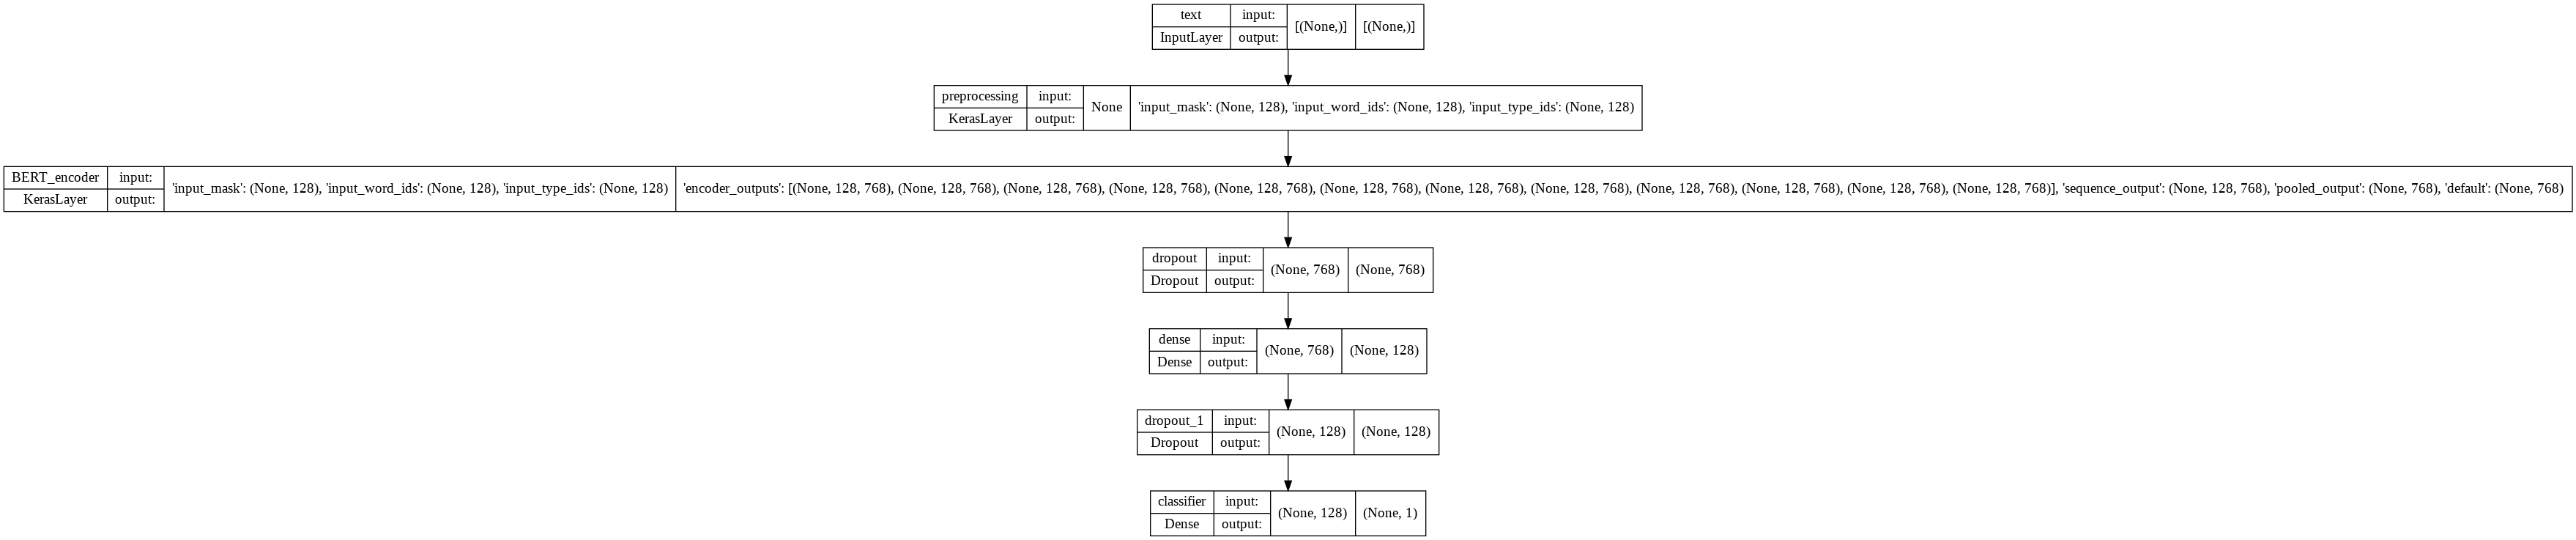

In [19]:
tf.keras.utils.plot_model(covid_fake_news_model, show_shapes=True)

In [20]:
history = covid_fake_news_model.fit(x=train_df.tweet.to_list(), y=train_df.label.to_list(),
                               validation_data=(val_df.tweet.to_list(), val_df.label.to_list()),
                               epochs=epochs)

Epoch 1/5
201/201 [==============================] - 431s 2s/step - loss: 0.3407 - binary_accuracy: 0.8410 - val_loss: 0.1766 - val_binary_accuracy: 0.9472
Epoch 2/5
201/201 [==============================] - 407s 2s/step - loss: 0.1118 - binary_accuracy: 0.9629 - val_loss: 0.1162 - val_binary_accuracy: 0.9626
Epoch 3/5
201/201 [==============================] - 407s 2s/step - loss: 0.0396 - binary_accuracy: 0.9880 - val_loss: 0.1477 - val_binary_accuracy: 0.9645
Epoch 4/5
201/201 [==============================] - 407s 2s/step - loss: 0.0139 - binary_accuracy: 0.9969 - val_loss: 0.1493 - val_binary_accuracy: 0.9729
Epoch 5/5
201/201 [==============================] - 409s 2s/step - loss: 0.0040 - binary_accuracy: 0.9989 - val_loss: 0.1446 - val_binary_accuracy: 0.9734


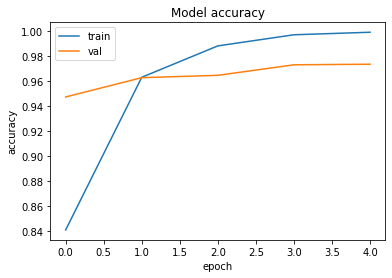

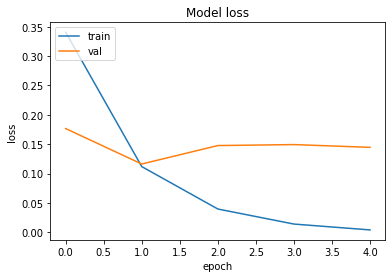

In [21]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [22]:
y_test = test_df.label.to_list()
y_pred = covid_fake_news_model.predict(test_df.tweet.to_list())

67/67 [==============================] - 9s 131ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


In [25]:
loss, accuracy = covid_fake_news_model.evaluate(test_df.tweet.to_list(), y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

67/67 [==============================] - 55s 823ms/step - loss: 0.1847 - binary_accuracy: 0.9692
Loss: 0.18467307090759277
Accuracy: 0.9691588878631592


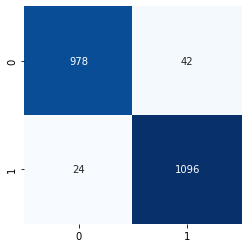

In [23]:
matrix_confusion = confusion_matrix(y_test, [1 if pred>0.5 else 0 for pred in y_pred])
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [24]:
covid_fake_news_model.save("/content/drive/MyDrive/Assignments/4.2/DM_Project/model/covid_fake_news_model")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/4.2/DM_Project/model/covid_fake_news_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/4.2/DM_Project/model/covid_fake_news_model/assets
